In [1]:
import os
import re
from collections import defaultdict
from pprint import pprint

import matplotlib.pyplot as plt
import nltk
import numpy as np
import omdb
import pandas as pd
import seaborn as sns
import sklearn
import spacy
from gensim.models import KeyedVectors, Word2Vec
from googleapiclient.discovery import build
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from wordcloud import WordCloud



pd.set_option('display.max_colwidth', None)
SPECIAL_CHARS = '[^A-Za-z0-9 ]+'
STOP_WORDS = stopwords.words('english')

# # use pre-trained corpus to help tokenise words
# nlp = spacy.load('en_core_web_sm')

# path = "GoogleNews-vectors-negative300.bin"
# w2v = KeyedVectors.load_word2vec_format(path, binary=True)
# It is much faster take less than 2 minutes


OMDB_API_KEY = os.environ.get('OMDB_API_KEY')
omdb.set_default('apikey', OMDB_API_KEY)

YOUTUBE_API_KEY = os.environ.get('YOUTUBE_API_KEY')
youtube = build('youtube','v3',developerKey=YOUTUBE_API_KEY)

# Youtube PIPELINE FUNCTIONS

In [2]:
def preprocess_text(text):
    """
    Take out stopwords.
    Take out punctuations and special characters.
    """
    SPECIAL_CHARS = '[^A-Za-z0-9 ]+'
    STOP_WORDS = stopwords.words('english')
    text = text.lower().split(' ')
    temp = [word for word in text if word not in STOP_WORDS]
    text = ' '.join(temp)
    text = re.sub(SPECIAL_CHARS, '', text)
    text = [w for w in text.split(' ') if w not in ['im','dont','cant','wont','shouldnt','couldnt','wouldnt']]
    return_text = ' '.join(text)
    return return_text

In [3]:
def preprocess_text_v2(text):
    """
    Take out fewer stopwords.
    Take out punctuations and special characters.
    """
    text = text.lower()
    text = re.sub(SPECIAL_CHARS, '', text)
#     text = [w for w in text.split(' ') if w not in ['im','dont','cant','wont','shouldnt','couldnt','wouldnt']]
#     return_text = ' '.join(text)
    return text

In [4]:
# test to retrieve 1000 comments
def get_1kcomments(videoId, preprocess=True):
    '''
    The function returns a list of 1000 comments.
    
    '''
    rq = youtube.commentThreads().list(
            part="snippet,replies",
            maxResults = 100,
            videoId=videoId)

    comments_list = list()
    nextPageToken = list()

    for i in range(10):
        if i == 0:
            try:
                rq = youtube.commentThreads().list(
                part="snippet,replies",
                maxResults = 100,
                videoId=videoId)
                rs = rq.execute()
                for i in range(100):
                    comments_list.append(rs['items'][i]['snippet']['topLevelComment']['snippet']['textOriginal'])

                nextPageToken.append(rs['nextPageToken'])
            except:
                continue
        else:
            try:
                rq = youtube.commentThreads().list(
                part="snippet,replies",
                maxResults = 100,
                videoId=videoId,
                pageToken=nextPageToken[i-1])
                rs = rq.execute()
                for i in range(100):
                    comments_list.append(rs['items'][i]['snippet']['topLevelComment']['snippet']['textOriginal'])

                nextPageToken.append(rs['nextPageToken'])
            except:
                continue
    if preprocess == True:    
        return [preprocess_text(comment) for comment in comments_list]
    else:
        return comments_list

In [5]:
def sentiment(preprocessed_comments):
    '''
    This function returns a dataframe consisting of polarity and subjectivity of the given movie reviews.
    '''
    polarity = list()
    subjectivity = list()
    for comment in preprocessed_comments:
        tb = TextBlob(comment)
        polarity.append(tb.sentiment[0])
        subjectivity.append(tb.sentiment[1])
    
    df = pd.DataFrame()
    df['polarity'] = polarity
    df['subjectivity'] = subjectivity
    return df

In [6]:
def create_wordcloud(preprocessed_comments, file_name='noID', max_font_size=150, max_words=100, background_color="white", save=False):
    all_comments = ','.join(preprocessed_comments).replace(',', ' ').replace('movie', ' ')
    wordcloud = WordCloud(max_font_size=max_font_size, max_words=max_words, background_color=background_color).generate(all_comments)
    wordcloud.to_file(file_name+'.png')
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    if save==True:
        name=input()
        plt.savefig(name+'.png')
    plt.show()

In [7]:
def sentiment_counts(df, sep=0.1):
    '''
    This function returns a dataframe containing the value counts of sentiment
    '''
    sent = defaultdict(int)
    for v in df['polarity']:
        if v > sep:
            sent['positive'] += 1
        elif v < -sep:
            sent['negative'] += 1
        else:
            sent['neutral'] += 1
    tempdf = pd.DataFrame(data = [sent], columns=['positive','neutral','negative'])
    tempdf = tempdf.transpose().reset_index().rename(columns={'index':'sentiment',0:'count'})
    tempdf['percentage'] = tempdf['count'].apply(lambda x: x/tempdf['count'].sum())
    
    return tempdf

In [8]:
def show_sentiment_counts(df, save=False):
    fig, ax = plt.subplots(figsize=(10,6))

    raw_count = sns.barplot(x='sentiment', y='count', data=df, ax=ax)
#     percentage = sns.barplot(x='sentiment', y='percentage', data=df, ax=ax[1])
    show_values_on_bars(ax)
#     show_values_on_bars(ax[1], round_out=False)
    ax.set_title('Counts')
#     ax[1].set_title('Percentage')
    if save==True:
        name=input()
        plt.savefig(name+'.png')
    plt.show()

In [9]:
def plot_sentiments(df, save=False):
    plt.figure(figsize=(10,6))
    sns.scatterplot(x='polarity', y='subjectivity', data=df)
    if save==True:
        name=input()
        plt.savefig(name+'.png')
    plt.show()

In [10]:
def show_values_on_bars(axs, h_v="v", space=0.4, round_out=True):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                if round_out == True:
                    value = int(p.get_height())
                    ax.text(_x, _y, value, ha="center") 
                else:
                    value = p.get_height()
                    ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                if round_out == True:
                    value = int(p.get_width())
                    ax.text(_x, _y, value, ha="left") 
                else:
                    value = p.get_width()
                    ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# Extraction YouTube Analysis

In [41]:
exId = "L6P3nI6VnlY"

### preprocess@1

In [42]:
extractionComments = get_1kcomments(exId, preprocess=False)

In [43]:
extractionComments_ppv2 = [preprocess_text_v2(comment) for comment in extractionComments]

 extractionSentCount


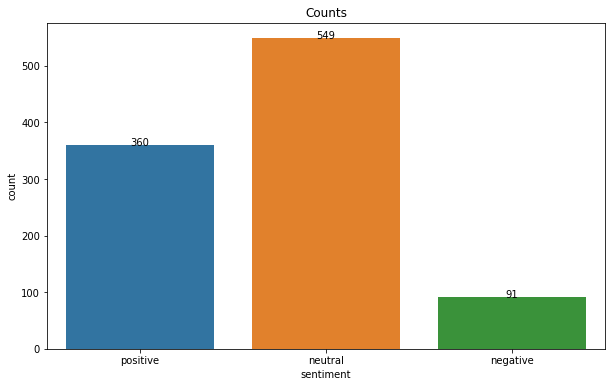

In [46]:
extractionSentiment = sentiment(extractionComments_ppv2)
extractionSentCount = sentiment_counts(extractionSentiment)
show_sentiment_counts(extractionSentCount, save=True)

 extractionWordcloud


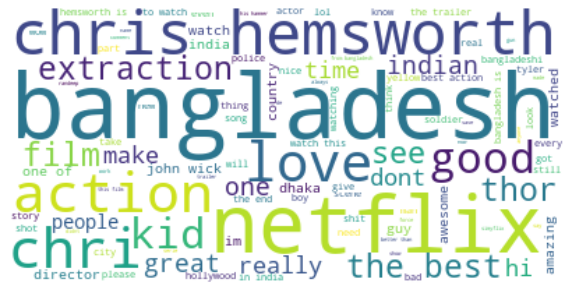

In [50]:
create_wordcloud(extractionComments_ppv2, save=True)

 extractionSent


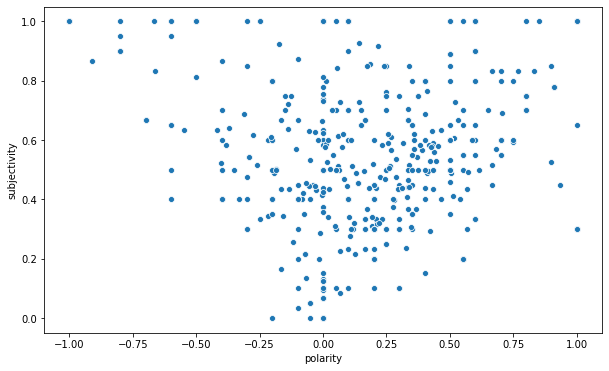

In [51]:
plot_sentiments(extractionSentiment, save=True)

In [73]:
extractionComments_ppv2

['at the end  is chris alive or that was a dream',
 '',
 'best movie of the year hands down 1010 no questions asked  just watch',
 'why they did that at the end  that is chris or',
 'the trailer almost reveals story',
 'song so good',
 '100100',
 'more movies like this',
 'seems like jon wick got competition ',
 'no oneliterally no onehollywood add yellow filter to give them vibes of mexico',
 'ending nya yaampunn',
 'must watch',
 'easily should be the best action film of 2020',
 'after he kills three hundred people ass he slices and dices his way through the city it gets a little much no one is that lucky',
 'boring im so tired of east indian muslim storylines  nothing left in hollydomei really hope it goes under soonits a joke',
 'perfect movie guns hemsworth sick car chase and gangs',
 'in shortcut this movie is better than 80 percent of indian stereotypes romantic movies ',
 'sobangladesh and india located in desertand bangladeshi small poor boys carry ak47how dangerous terrorist 

# The silence

In [52]:
silenceId = "Y-ufZuqTd5c"

In [62]:
silenceComments = get_1kcomments(silenceId, preprocess=False)

In [63]:
silenceComments_ppv2 = [preprocess_text_v2(comment) for comment in silenceComments]

 silenceSentCount2


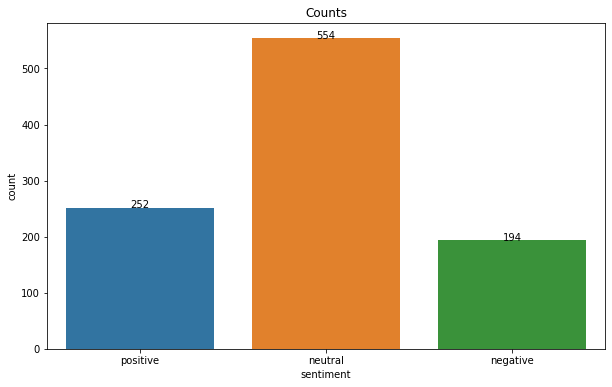

In [59]:
silenceSent = sentiment(silenceComments)
silenceSentCount = sentiment_counts(silenceSent)
show_sentiment_counts(silenceSentCount, save=True)

 silenceWC2


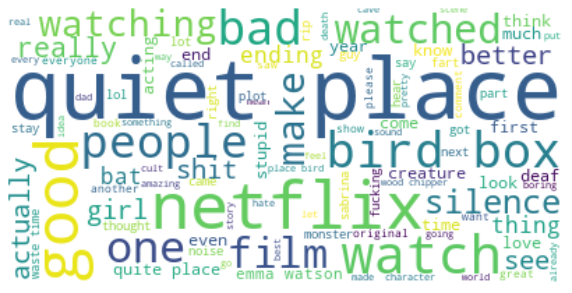

In [60]:
create_wordcloud(silenceComments, save=True)

In [65]:
silenceComments_ppv2

['this was one of the worst movies ive seen the entire year',
 'nice movie',
 'corona cant go outside',
 'not the best acting but worth the watch',
 'what a stupid movie is this',
 'the only question in my mind  is why they  leave the house and why they choose car ',
 'wannabe quiet place',
 'movie reviewtowards the end youre thinking thats the big bad guy of the storywow they killed them pretty fast when the movie ends youre like thats the endfinal score 310it seemed promising just to fall flat',
 'same timeline of the quiet place xd',
 'and also the movie hush ',
 'and    bird  box',
 'this reminds me of the movie  a quiet  place chapter one and two',
 'cant fart covid 21  december 2020 release',
 'meh this movie is pointless they could have made a luring sound that leads to a firepit or shredder for these creatures',
 'tbh if instead were a serie this could be interesting all the plot was rushed also cmon a cult only one day before all begins i will accept if all the plot happens 5 

In [66]:
hieId = "WJyyJ7lexnM"
hieComments = get_1kcomments(hieId, preprocess=False)

In [67]:
hieComments_ppv2 = [preprocess_text_v2(comment) for comment in hieComments]

 hieSentCount


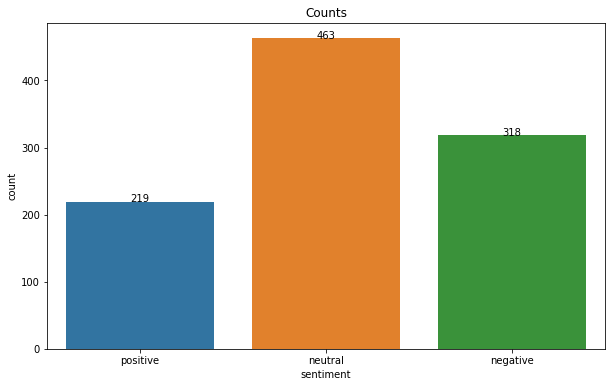

In [68]:
hieSent = sentiment(hieComments_ppv2)
show_sentiment_counts(sentiment_counts(hieSent), save=True)

 hieWc


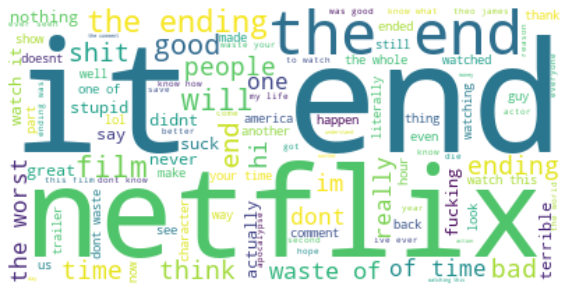

In [71]:
create_wordcloud(hieComments_ppv2, save=True)

In [72]:
hieComments_ppv2

['feel like this movie lost meaning 30 minutes in  i know you understand ',
 'this movie is the prequel to the book and movie the road looks like it could be at least if it wanted to be',
 'why its trending nowi have netflixmay be i shouldnt try',
 'stupid movie',
 'they should put a question mark at the end of that title because it literally doesnt tell you how it ends its like they ran outta money so the movie suddenly stopped',
 'estaba buscando una cancion y termin topandome con esta mierda',
 'after watching the trailer which is total shit so i came to the comments section now im  feeling bad for wasting my 2 minutes and 38 seconds',
 'just because i can see theo jamess face for 1h and 53mins i love this movie',
 'ahh thanks for the comments im not gonna watch it anymore',
 '2 years later and still waiting to see how it ends ',
 'this movie was dumb dont waste your time ',
 'this is the most boring movie ive ever watched',
 'beautiful bfx  matchlless',
 'actor is looking like paul

# Umbrella

In [11]:
umbId = "0DAmWHxeoKw"

In [12]:
umbComments = [preprocess_text_v2(comment) for comment in get_1kcomments(umbId, preprocess=False)]

 umbSC


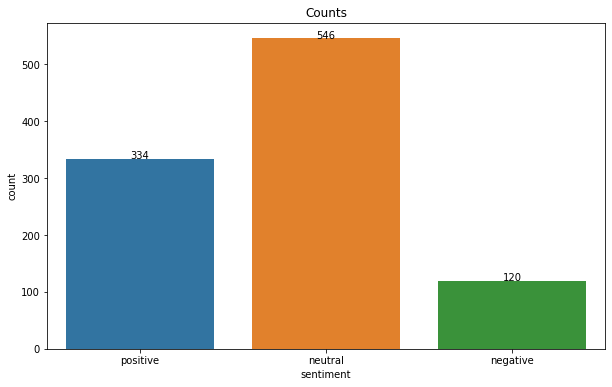

In [13]:
umbSent = sentiment(umbComments)
umbSentCount = sentiment_counts(umbSent)
show_sentiment_counts(umbSentCount, save=True)

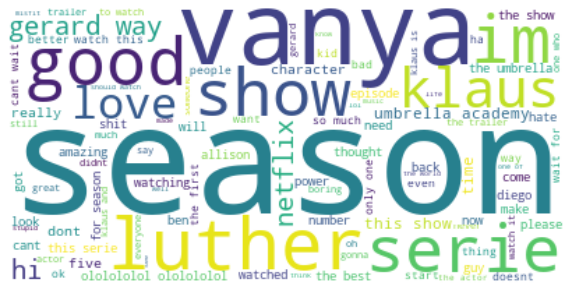

In [14]:
create_wordcloud(umbComments)

In [24]:
umbComments

['not bad',
 'who is there after season 2 i love this weird show so much lol',
 'umbrella academy the story of seven special unique individuals with a superhuman lack of any personality or charisma whatsoever',
 'we all could tell vanya was gone be the problem from the start smh',
 'why do they say suicide is in the show when it is not any show that has suicide on netflix they promote and encourage people to seek help why do they have this word posted at the beginning of every episodenot cool',
 'klaus is a great actor and five too  others are good too less luther this charactere is dumb i deplore the fact that we have to see gay couple appear in all series even though it did not be avis dune franaisei like this serie  ',
 'meh',
 'can a season 3 plz come bro show is good afff',
 'season2 is way interesting than 1st seasonlike if you agree',
 'hello the netflix i need this for a video do i have the permission to use it',
 'the umbrella academy is so badass excellent show and cast',
 'g

# stranger s1

In [15]:
strgId = "b9EkMc79ZSU"

In [16]:
strgComments = [preprocess_text_v2(comment) for comment in get_1kcomments(strgId, preprocess=False)]

 stragSC


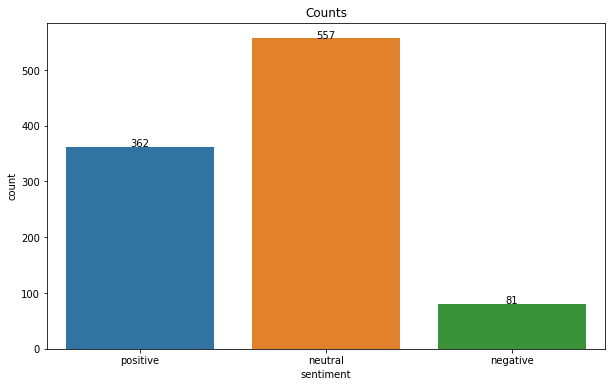

In [17]:
strgSentCount = sentiment_counts(sentiment(strgComments))
show_sentiment_counts(strgSentCount, save=True)

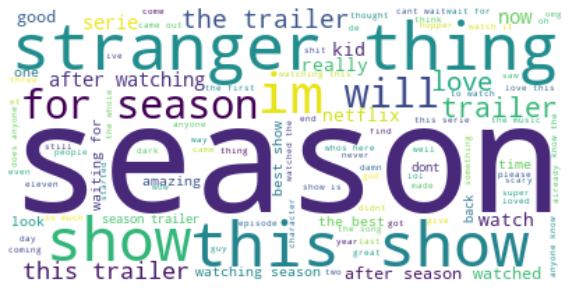

In [18]:
create_wordcloud(strgComments)

In [25]:
strgComments

['stroy line is likee dark',
 'its been a long time  i gave up after 4 or 5 episods of the season 1',
 'eleven is my  fav character ',
 'well the whole thing',
 'omg i watched this',
 '',
 'where theres a will theres a way ',
 'ce que jaime le plus de cette srie cest que tous les enfants font un trs bon rle les enfants jouent  un jeu dont ils parlent tout le temps dans la srie il dcouvre que les mystres du jeu passent dans le monde rel dans un autre ralit quils appellent the upside down  et que se trouve sous la ville de hawkins o ils habitent mon personnage prfre est dustin un petit garon courageux qui cherche toujours la prochaine aventure le genre de la srie est un mlange de thriller avec un peu de comdie',
 'me coming here 4 years later and seeing how much these kids have actually grown up like holy shit',
 'show de bola ',
 'i recreated a scene on my channel',
 'i wish season 4 will have the same tone and vibe as this first season',
 'goooddddd',
 'money heist wale idhar attendanc

# daybreak

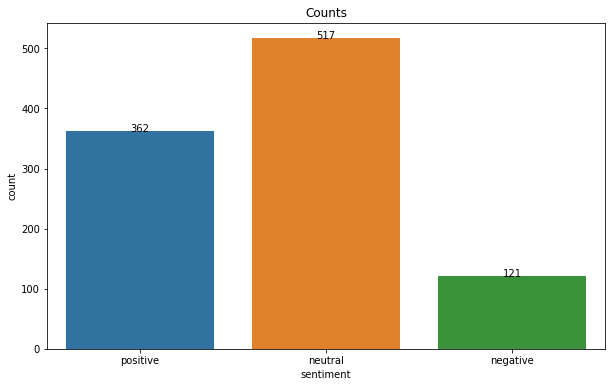

In [19]:
dbId = "2P9U41e75tE"
dbComments = [preprocess_text_v2(comment) for comment in get_1kcomments(dbId, preprocess=False)]
dbSentCount = sentiment_counts(sentiment(dbComments))


 dbSC


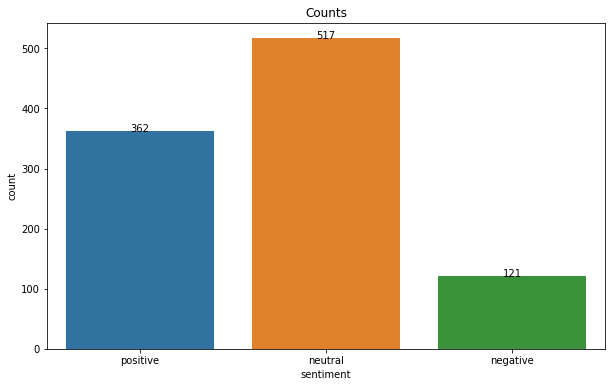

In [20]:
show_sentiment_counts(dbSentCount, save=True)

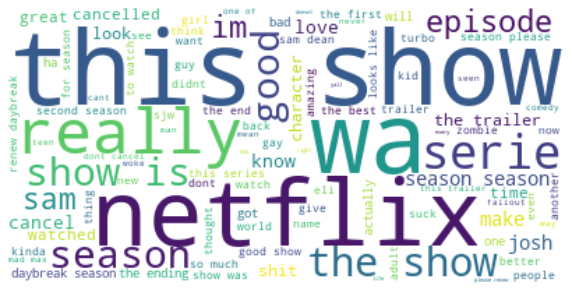

In [21]:
create_wordcloud(dbComments)

In [26]:
dbComments

['in the the end the girl show her real personnality',
 '2 seasooooooooon2 temporaaaaaaada',
 'make a season 2',
 'oh is the young sam winchester',
 'im so mad because netflix always cancel every nice show',
 'ms crumble is like damn just appeared after the bomb was launch',
 'i dont know what is his name i know him as berry alenthe flash',
 'what do we do if theres intruders in golf clubmedie',
 'make next why u denied',
 'i know this shows is not perfect mustwatched or so but its good and hilarious enough to watch the entire show typically darkcomdey gerne',
 'underrated',
 'what i really wanna know is who is running municipal water and electricity service if the adults and zombies and an emp nuked everything because theres no way a bunch of teenagers are this on top of laundry without machines doing it for them',
 'the only show tralier that wasnt bad is stranger things',
 'need season 2 netflix think on it',
 'the trailer and the movie is full of orange colourexcept netflix title',

# Black summer

 bsSC


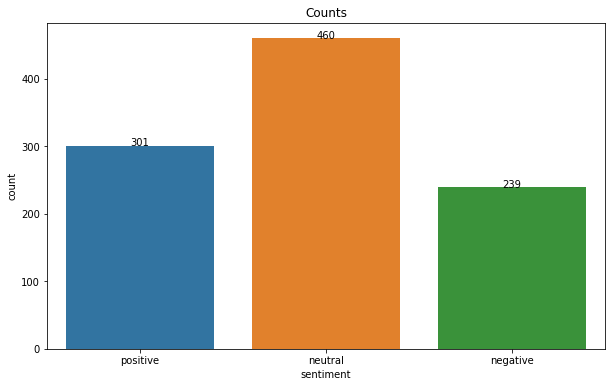

In [22]:
bsId = "tQA1omPJN24"
bsComments = [preprocess_text_v2(comment) for comment in get_1kcomments(bsId, preprocess=False)]
bsSentCount = sentiment_counts(sentiment(bsComments))
show_sentiment_counts(bsSentCount, save=True)

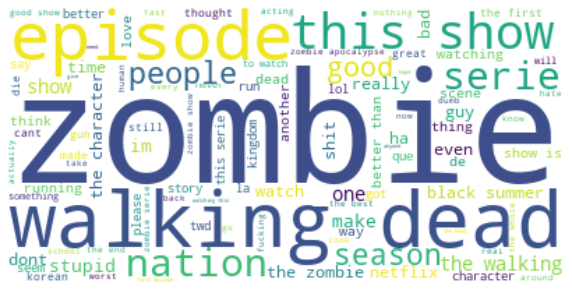

In [23]:
create_wordcloud(bsComments)

In [27]:
bsComments

['can you just bring back z naiton',
 'it said the only thing that make us human smh grammarly is still an app xd',
 'most dumbest zombie movie ive ever watcheddont waste your time on this felllasi speak the truth and the truth speaks me',
 'phenomenal series',
 'at least take one from characters from z nation if you want to make this prequel from z nationcome ondoc or 10k or murphy',
 'you can watch the full movie in netflix that really good i like ita little bit horror',
 'this show is a piece of shit',
 'carl their zombies run faster than or zombies they run fast carl',
 'try znation if you havent its my favorite',
 'a serie mais idiota q j assistir',
 'season 1 episode 1  a mute guy stands around looking helpless waiting for anything bad to happen repeatedly  just stands around waitingseason 1 episode 4  a guy walks into a building because the door is not locked he makes his way up and on to the roof  then rather than walk back down the same way he decides for no reason whatsoever 